In [81]:
import tensorflow as tf

import pandas as pd
import sklearn as sk

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
%pylab inline

# Using the tutorial at https://www.tensorflow.org/tutorials/keras/basic_regression


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hist', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [82]:
df = pd.read_hdf('../database/merged_v3_data.hd5','table')
#df = pd.read_hdf('../database/merged_v3_datetime_selected_10min.hd5','table')

df = df.dropna()

l1_ = len(df)
df = df[df['Speed 1 (rpm)'] > 50]
df = df[df['Speed 1 (rpm)'] < 100]# Filter out all points outside 50-100 rpm.
l2_ = len(df)
print('Number of datapoints filtered out: ', l1_-l2_, ' relative, ', (l1_-l2_)/l1_)


features_all = list(df)

for i in range(len(features_all)):
    print(i,features_all[i])

label = features_all[0] # Consumpt 1 is for the ME

#test_features = [label,features_all[2],features_all[3],features_all[5],features_all[6]] # Using Torque, Speed rpm, Ship speed (log)
test_features = [label,features_all[2],features_all[3],features_all[5],features_all[6],features_all[7]] # Using Torque, Speed rpm

#test_features = [label,features_all[2],features_all[3]]

print('Features :'+ str(test_features))

Number of datapoints filtered out:  1989  relative,  0.02034761792718233
0 Consump1 Rate (kg/h)
1 Consump2 Rate  (kg/h)
2 Torque 1 (kNm)
3 Speed 1 (rpm)
4 Power1 (kW)
5 SpeedlogSpeed (kn)
6 Gps Speed (kn)
7 Aux Power1 (kW)
Features :['Consump1 Rate (kg/h)', 'Torque 1 (kNm)', 'Speed 1 (rpm)', 'SpeedlogSpeed (kn)', 'Gps Speed (kn)', 'Aux Power1 (kW)']


In [84]:
# Create new dataframe for training

df_train = pd.DataFrame()
for n_ in test_features:
    df_train[n_] = df[n_]

X = np.array(df_train)
y = np.array(df[label])

# Make a train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

train_dataset = df_train.sample(frac=0.75,random_state=42)
test_dataset = df_train.drop(train_dataset.index)


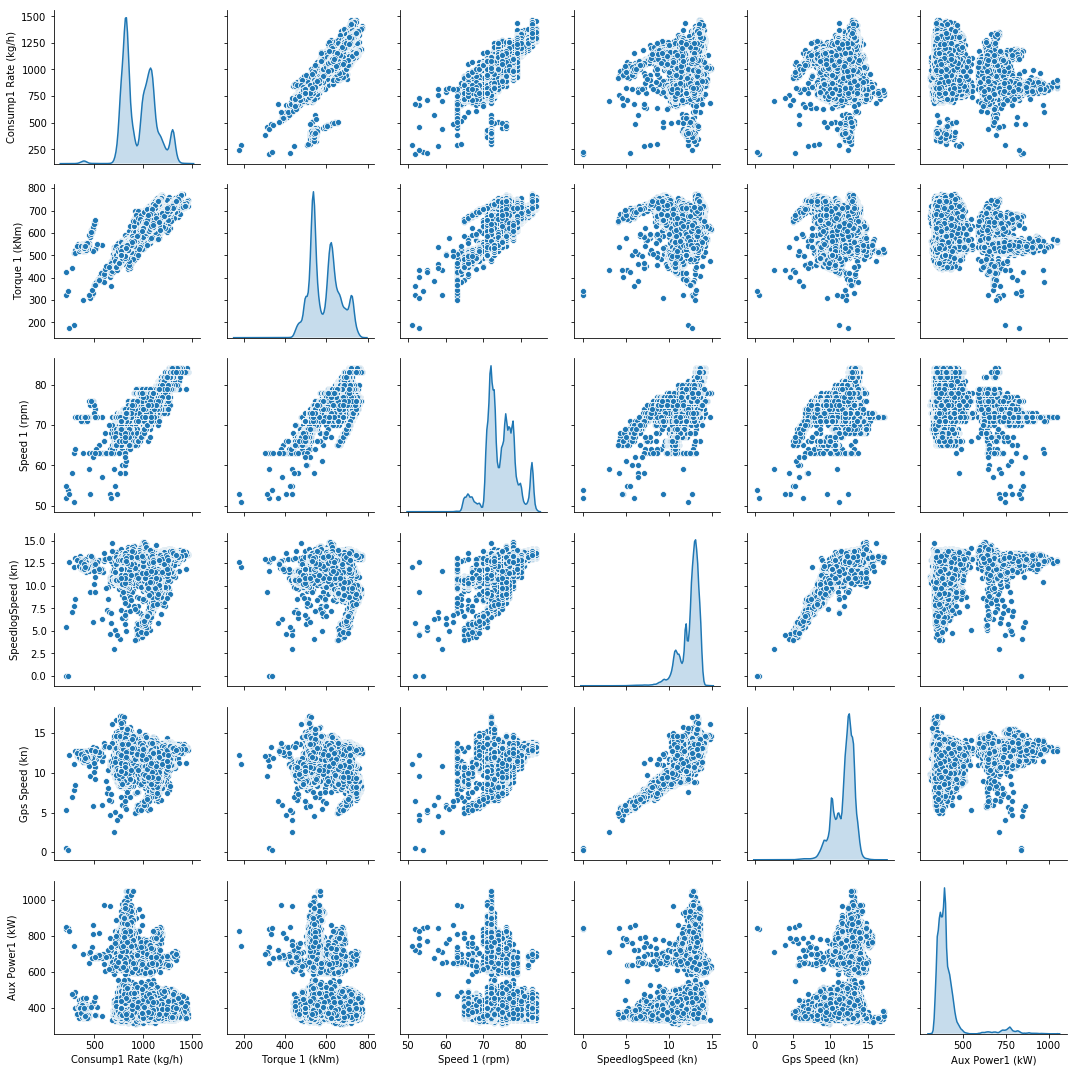

In [85]:
sns.pairplot(train_dataset, diag_kind="kde")

In [86]:
train_stats = train_dataset.describe()
train_stats.pop(label)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Torque 1 (kNm),71822.0,594.178497,71.935636,176.0,535.0,597.0,644.0,772.0
Speed 1 (rpm),71822.0,74.708028,3.974052,51.0,72.0,75.0,77.0,84.0
SpeedlogSpeed (kn),71822.0,12.357494,1.163379,0.0,11.9,12.7,13.1,14.8
Gps Speed (kn),71822.0,11.886433,1.325190,0.3,11.0,12.2,12.8,17.1
Aux Power1 (kW),71822.0,414.088845,95.642367,310.0,368.0,391.0,418.0,1050.0


In [87]:
train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

In [88]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [89]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()


In [90]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
__________

In [91]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.00877918],
       [0.00173669],
       [0.00813952],
       [0.00234895],
       [0.00512585],
       [0.00625187],
       [0.00099038],
       [0.0166947 ],
       [0.000252  ],
       [0.00037565]], dtype=float32)

In [92]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [93]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1457.550913,22.265097,1457.551025,2978.409228,43.180443,2978.409424,995
996,1463.338722,22.306189,1463.338623,1323.761930,16.756636,1323.762329,996
997,1471.813080,22.344673,1471.812500,1336.715896,17.480900,1336.715820,997
998,1471.568302,22.273855,1471.568115,1324.500848,16.475557,1324.500610,998
999,1463.589588,22.358074,1463.590820,1617.534559,24.435104,1617.534546,999


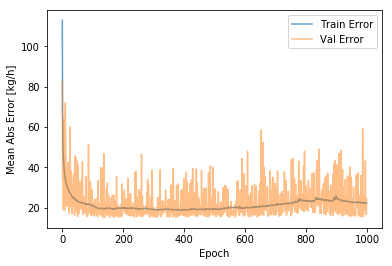

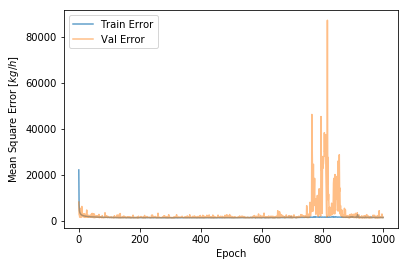

In [94]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [kg/h]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error',alpha=0.7)
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error',alpha=0.5)
  #plt.ylim([18,100])
  plt.legend()
  
  plt.savefig('deep-NN-training-error.ps')  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$kg/h$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error',alpha=0.7)
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error',alpha=0.5)
  #plt.ylim([0,10000])
  plt.legend()
  plt.show()


plot_history(history)

Deep NN R2: 0.9336652022636396
Mean absolute percentage error Deep NN 2.8073457322760285 %


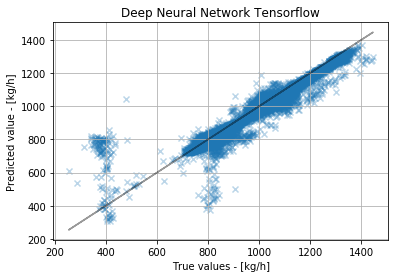

In [95]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.3,marker='x')
plt.plot(test_labels,test_labels,color='black',alpha=0.4)

plt.title('Deep Neural Network Tensorflow')
plt.grid()

plt.xlabel('True values - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('deep-NN-predict.ps')


R2_train = r2_score(test_predictions,test_labels)
print('Deep NN R2:', R2_train)


error = mean_absolute_percentage_error(test_labels,test_predictions)
print('Mean absolute percentage error Deep NN', error,'%')


#plt.axis('equal')
#plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])


.........................

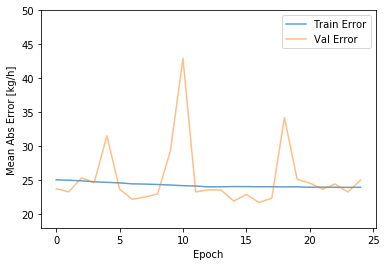

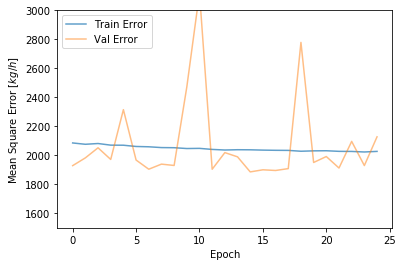

In [16]:
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

#plot_history(history)


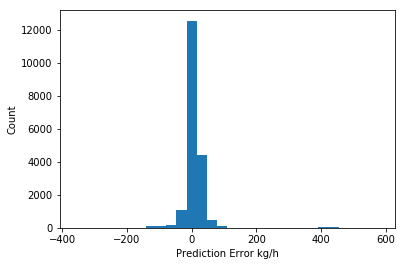

In [73]:
error = test_predictions - test_labels
plt.hist(error, bins = 30)
plt.xlabel("Prediction Error kg/h")
_ = plt.ylabel("Count")